<a href="https://colab.research.google.com/github/Musa-Ali-Kazmi/Medical-VQA/blob/main/Medical_VQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VQA DATA

In [1]:
!pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 21.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [3]:
import re
import os
import shutil
from datasets import load_dataset
import pandas as pd
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

from torchvision.transforms import Compose, Resize, ToTensor

In [4]:
dataset = load_dataset("flaviagiammarino/vqa-rad")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1793 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/451 [00:00<?, ? examples/s]

In [5]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 1793
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 451
    })
})


In [6]:
np.array(dataset["train"][0]["image"]).shape

(555, 566, 3)

In [7]:
resize = jitter = Compose(
    [
         Resize(size=(224,224)),
         ToTensor(),
    ]
)

def resize_transform(image):
    return resize(image)

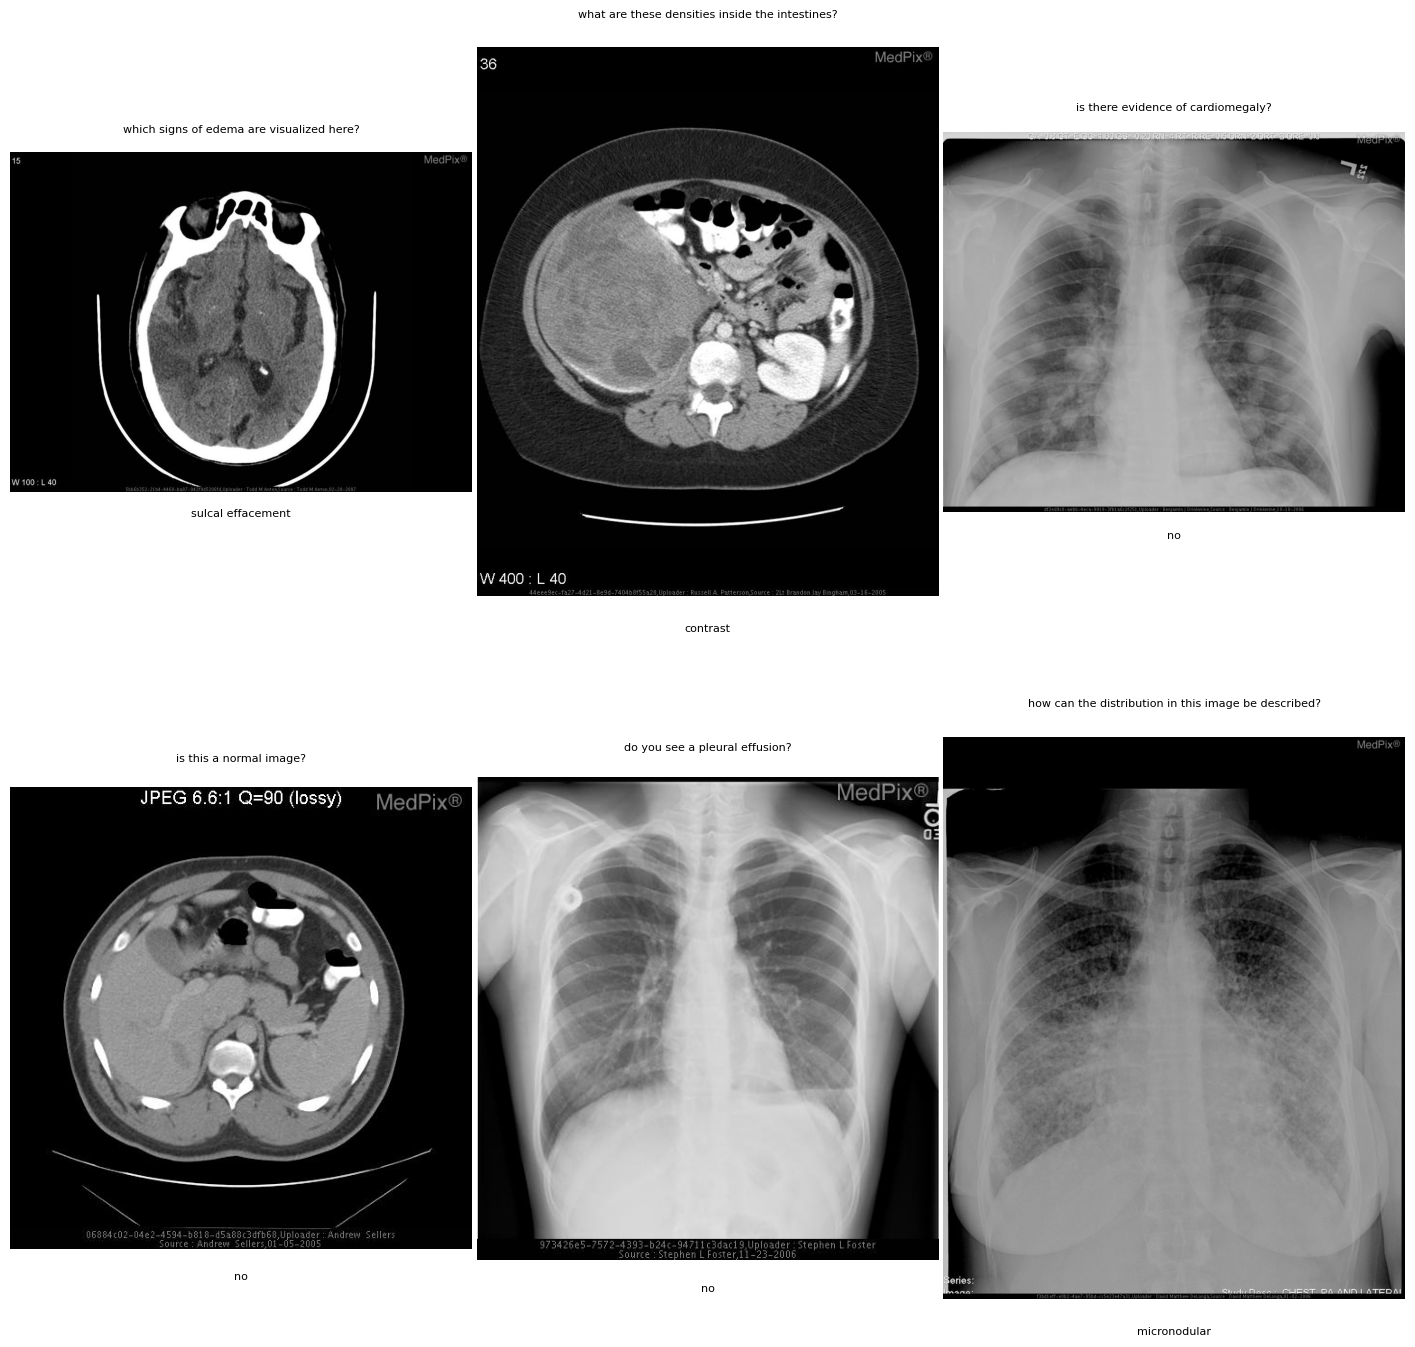

In [18]:
random_samples = dataset["train"].shuffle().take(6)
# Print the random samples
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 18))
print()
for i, ax in enumerate(axes.flat):
    ax.imshow(random_samples[i]["image"])
    ax.text(0.5, 1.05, random_samples[i]["question"], ha='center', va='bottom', transform=ax.transAxes, fontsize=8)
    ax.text(0.5, -0.05, random_samples[i]["answer"], ha='center', va='top', transform=ax.transAxes, fontsize=8)
    ax.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()

In [24]:
questions = []
answers = []

for example in dataset['train']:
    questions.append(example['question'])
    answers.append(example['answer'])

# Create a pandas DataFrame
df_QA = pd.DataFrame({
    'question': questions,
    'answer': answers
})

# Display the DataFrame
print(df_QA.head())

                                            question          answer
0                are regions of the brain infarcted?             yes
1                    are the lungs normal appearing?              no
2      which organ system is abnormal in this image?  cardiovascular
3  is the lesion causing significant brainstem he...              no
4                          how was this image taken?             mri


In [36]:
from torch.utils.data import DataLoader


In [40]:
train_dataloader = DataLoader(dataset['train'], batch_size=4, shuffle=True)

In [41]:
batch = next(iter(train_dataloader))

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.JpegImagePlugin.JpegImageFile'>

# Model Building


In [11]:
from transformers import ViltConfig

config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/136k [00:00<?, ?B/s]

In [ ]:
print(config.label2id["down"])

267


In [12]:
import torch
from PIL import Image
from transformers import ViltConfig

config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

In [13]:
from transformers import ViltForQuestionAnswering

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm",
                                                 id2label=config.id2label,
                                                 label2id=config.label2id)
model.to(device)

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.1.bias', 'classifier.1.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

# Vilt VQA Inference

In [42]:
from transformers import ViltProcessor, ViltForQuestionAnswering
import requests
from PIL import Image


for example in dataset['train']:
    image = example['image']
    break


text = questions[0]

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

# prepare inputs
encoding = processor(image, text, return_tensors="pt")

# forward pass
outputs = model(**encoding)
logits = outputs.logits
idx = logits.argmax(-1).item()
print("Predicted answer:", model.config.id2label[idx])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/470M [00:00<?, ?B/s]

Predicted answer: yes


In [46]:
range = 10
for example in dataset['train']:
    image = example['image']
    question = example['question']
    answer = example['answer']

    # prepare inputs
    encoding = processor(image, question, return_tensors="pt")

    # forward pass
    outputs = model(**encoding)
    logits = outputs.logits
    idx = logits.argmax(-1).item()
    print("Question: ", question)
    print("Predicted answer:", model.config.id2label[idx])
    print("Actual answer: ", answer)
    print("---------------------------------------------END--------------------------------")
    range-=1

    if range==0:
      break



Question:  are regions of the brain infarcted?
Predicted answer: yes
Actual answer:  yes
---------------------------------------------END--------------------------------
Question:  are the lungs normal appearing?
Predicted answer: no
Actual answer:  no
---------------------------------------------END--------------------------------
Question:  which organ system is abnormal in this image?
Predicted answer: middle
Actual answer:  cardiovascular
---------------------------------------------END--------------------------------
Question:  is the lesion causing significant brainstem herniation?
Predicted answer: yes
Actual answer:  no
---------------------------------------------END--------------------------------
Question:  how was this image taken?
Predicted answer: camera
Actual answer:  mri
---------------------------------------------END--------------------------------
Question:  what is the condition of the patient
Predicted answer: bad
Actual answer:  blind loop syndrome
--------------